# Grover's algorithm 

*Author*: Júlia Barberà, March 3rd 2022

This notebook presents a demonstration of how Grover's algorithm performs when we want to find an element from a list. It also shows how the results converge as $\sqrt(N)$ with $N = 2^{nqubits}$.
 <br>
 
We use an arbitrary number of qubits, in our case 3, to show the results but it could be done with a different value of $nqubits$. 

The code is written using Qibo language and qibojit, qibotf, tensorflow, numpy simulator as a default backend.

__Table of contents:__
1. Defining functions
    1. Binary to decimal function
    1. MCZ gate 
    1. Grover's Oracle 
    1. Diffusion operator 


2. Main code: Grover's algorithm
    1. Grover's algorithm for 5 qubits
    1. Plots
    
    
3. Scan with n=2,...,8 qubits
    1. Quantum algorithm (Grover's)
    1. Classical algorithm
    1. Plot comparison

In [2]:
# Import all libraries that I will use
import numpy as np
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt

## Functions


Firstly, we introduce some functions that we will use in the main code. They will be universal for any state we want to find. 

### Binary to decimal function

There are two methods to convert a binary number into a decimal number and we will be using one of them: using the positional notation. The weight of the positions will be $2^0, 2^1, 2^2, 2^3,...$ so the first thing we need to do is count the number of digits (positions) the binary number has. Then, these weigths will be multiplying the digit corresponding to its binary number (0 or 1). Finallly, we will sum everything. Let's assume our binray number is $10110$:


<br>

<center> decimal number $= 1 \cdot 2^4 + 0 \cdot 2^3 + 1 \cdot 2^2 + 1 \cdot 2^1 + 0 \cdot 2^0 = 22 $ </center>


<br>

The binary state will be the one we want to find and we will use this function to convert the state in order to find the inverting matrix. 

In [4]:
def binary_to_decimal(binary_number):
    decimal_number = 0 #Initialize the number 

    for position, string_digit in enumerate(binary_number[::-1]):
        decimal_number += int(string_digit) * 2 ** position

    return decimal_number


### Multi-controlled Z gate 

The CZ gate is used to invert the phase of the state $|11...1\rangle$. To make it easier we can express the CZ gate in terms of other quantum logic gates: $Z = H X H$. 
So the MCZ of the circuit will have the following transformation: 

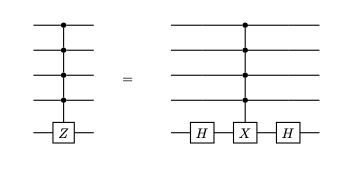

We will use this gate for the Oracle and the Diffusion operator. 

In [5]:
def MCZ(q0,nqubits): # defining multi-controlled Z function 
    c.add(gates.H(q0))
    c.add(gates.X(q0).controlled_by(*range(1,nqubits)))
    c.add(gates.H(q0))
    return c 

### Grover's oracle: $U_w$

The Grover's oracle generates a reflection to the state we want to find. Imagine we have the following superposition ($nqubits = 2$): $|s\rangle = \frac{1}{\sqrt{2}} (|00 \rangle +|01 \rangle +|10 \rangle +|11 \rangle) $ and we want to find the state $|10 \rangle$. When we apply the oracle to the initial state it will turn into: <center> $U_w|s\rangle = \frac{1}{\sqrt{2}} (|00 \rangle +|01 \rangle -|10 \rangle +|11 \rangle) $ 
    
We can recognize that the CZ quantum gate is the one that performs this operation. But firstly, we will create a classical diagonal matrix filled with ones on the diagonal except the position that corresponds to the state we want to find which will have the value -1 in order to flip the state.  

In [6]:
def oracle_general(nqubits,state):
    
    inv_matrix = np.zeros( (2**nqubits, 2**nqubits) ) 

    for i in range(0,2**nqubits):
        for j in range(0,2**nqubits):
            if i == j:
                if i == state : 
                    inv_matrix[i][j] = -1 #add a -1 in order to flip the state
                else:
                    inv_matrix[i][j] = 1 

    return c.add(gates.Unitary(inv_matrix,*range(0,nqubits)))
    

### Grover's diffusion operator: $U_s$

This operator, expressed like: $U_s = 2|s\rangle \langle s | - I$,  will be applied after the Oracle, and will perform an extra reflection to the state $U_w |s\rangle$. It will aplificate the state we want to find, making it have a much greater probability than the other ones. The Diffusion operator will have the following universal form : 

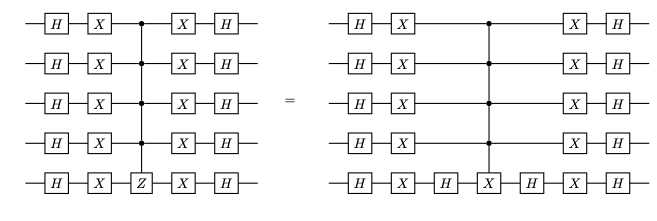

The hadamard gates will create a superposition of all states. Then, the X gate performs a qubit-flip (it is the equivalent to the NOT classical gate) so it makes a rotation by π radians around the x-axis of the Bloch sphere. When we have the states fliped...

In [7]:
def diffusion(q0,nqubits): 

    c.add([gates.H(i) for i in range(nqubits)])     
    c.add([gates.X(i) for i in range(nqubits)])   
    MCZ(q0,nqubits) #q0 is the target and the other ones, control qubits
    c.add([gates.X(i) for i in range(nqubits)])
    c.add([gates.H(i) for i in range(nqubits)])
    
    return c

## Main code: Grover's algorithm 

The purpose of the program is to find a given state as an input. In this section we will apply the Grover's algorithm to 3 qubits and show that the probability to find the one we want is the highest between all the possibilities. 
Moreover, we will plot an histogram showing probabilities of states and another plot will show how the maximum probability increases as we apply the Grover's iterator more times. 

### Grover's algorithm for 3 qubits

The code follows the next procedure to find the state: 
    
1. Asks the number of qubits of the circuit and the state you want to find. 
2. Calculates R corresponding to repetitions of the Grover's iterator. The more times we apply the oracle, the higher probability we will get. (demonstration of the following equation) 
<br>

<center> $R = \frac{\pi}{4}\cdot \sqrt{N}$ </center>

<br>

3. Starts a loop where it will run the full Grover's algorithm for each R: 
- It will create the circuit 
- Apply Hadamard gates for superposition
- Apply the Grover's iterator
- Execute the circuit in order to find the result 
- Add to a list the maximum probability corresponding to the state we want   
    
4. Draws the circuit. 

In [8]:
nqubits = int(input("How many qubits does the circuit have? "))
state = int(input("Which state do you want to find? "))
probs = [ ] #probabilities of the target
print()

R = int((np.pi/4)*np.sqrt(2**nqubits))
print("Number of times we apply the oracle = ", R)
print()

for k in range(1,R+1):
    c = Circuit(nqubits) # Construct the circuit (2 qubits)
    c.add([gates.H(i) for i in range(nqubits)])
    for j in range(k):
        # Rotation of the state we are searching for
        oracle_general(nqubits,state) 
        diffusion(0,nqubits)
         
   # Execute the circuit and obtain the final state
    result = c()
    y = result.state(numpy=True)
    probs.append(max([x.real*x.real for x in y]))

# Draw the circuit
print(c.draw())

How many qubits does the circuit have? 3
Which state do you want to find? 3

Number of times we apply the oracle =  2

q0: ─H─U─H─X─H─X─H─X─H─U─H─X─H─X─H─X─H─
q1: ─H─U─H─X───o─X─H───U─H─X───o─X─H───
q2: ─H─U─H─X───o─X─H───U─H─X───o─X─H───


### Plots

These plots will show, from all states available (created by nqubits), the one with more probability which corresponds to the one we were searching for and how this probability increases as we apply more times the Grover's iterator. 

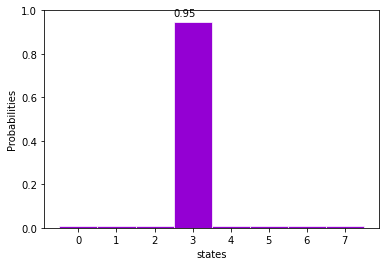

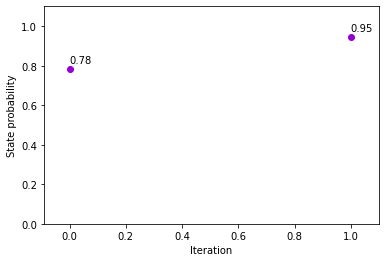

In [9]:
# FINDING STATE 
x = range(2**nqubits) 
y = result.state(numpy=True)

prob = [x.real*x.real for x in y] # elevating coeficients = probability 

fig, ax = plt.subplots()

ax.bar(x, prob, width=1, edgecolor="white",color = "darkviolet", linewidth=0.7)
ax.set(ylim=(0, 1), xlabel = 'states', ylabel = 'Probabilities')

ax.text(prob.index(max(prob))-0.5,max(prob)+0.03, str(round(max(prob),2)), fontsize=10)

plt.show()

# MAX. PROBABILIY 
oracle_times = range(R) 
plt.plot(oracle_times, probs,'o', color = "darkviolet")
plt.xlim([0 -0.09 ,R -0.9])
plt.ylim([0,1.1])
plt.xlabel('Iteration')
plt.ylabel('State probability') 

i=0 #writes the probability of each state 
for el in probs:
    plt.text(oracle_times[i],el+0.03, str(round(el.real, 2)), fontsize=10)
    i=i+1
    
plt.show()

## Scan with n=2,...,8 qubits

In order to compare the performance of the classical method and the quantum one, we will try to find the state 3 changing the number of qubits of the circuit form 2 to 9. We will calculate the time for each iteration and times we apply the oracle to find the state. 

### Quantum algorithm (Grover's)

Firstly, we will apply the Grover's algorithm (quantum method), using a loop in order to change the number of qubits from 2 to 9. 

In [10]:
state = int(input("Which state do you want to find? "))
probability = [ ]
q_oracle = [ ]
print()

for nqubits in range(2,9):

    c = Circuit(nqubits) # Construct the circuit (2 qubits)
    c.add([gates.H(i) for i in range(nqubits)])

    R = int((np.pi/4)*np.sqrt(2**nqubits)) #time we apply the oracle 
    
    for i in range(1,R+1):
        # Rotation of the state we are searching for 
        oracle_general(nqubits,state) 
        diffusion(0,nqubits)
    
    # Execute the circuit and obtain the final state
    result = c() 
    y = result.state(numpy=True)
    probability.append(max([x*x.conjugate() for x in y]))
    q_oracle.append(R)

Which state do you want to find? 3



### Classical algorithm

We know that Grover's algorithm reduces the time needed to find the state and that the result converges as $\sqrt N$ with $N = 2^{nqubits}$, so we can use the previous section to compare it with the performation of the classical method to find an element of a list. 

We should see that the classical method escalates as $N$, much slower than the quantum performance. 
- We will create a list corresponding to all states available 
- A loop (equivalent to the oracle) will search element by element from the list until it finds the state we wanted
- At the begining we will initiate a counter in order to know how many elements of the list the code has checked to know if the state was in that position

In [11]:
c_oracle = [ ]

for nqubits in range(2,9):
    states_list = np.arange(2**nqubits)
    np.random.shuffle(states_list)
    
    i=0
    for el in states_list:
        if el == state:
            c_oracle.append(i)
        i +=1

### Plot comparision 

Here we can see two plots: one that shows time to find the state vs number of qubits and the other one shows times we apply the oracle vs number of qubits using the classical and quantum algorithm. We can, indeed, see how the time to find the state with the classical method is higher than the one spent to find the state by the quantum method (encara no és així perquè estem utilitzant amtriu classica). Also, the number of times we apply the oracle coverges as N classicaly, and as $\sqrt N$ when we use the Grover's algorithm. 

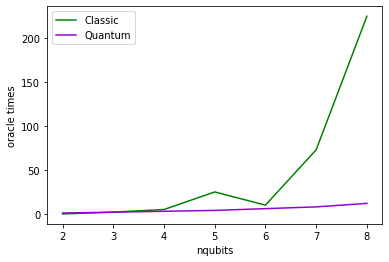

In [12]:
x = range(2,9) #nqubits list 

# oracle times vs nqubits
plt.plot(x,c_oracle, label = "Classic", color = "green")
plt.plot(x,q_oracle, label = "Quantum", color = "darkviolet")
plt.xlabel("nqubits")
plt.ylabel("oracle times")
plt.legend()

plt.show()